Plot the number of links scoring above a threshold for the different media. The x-axis is defined by the scores for all media, i.e. a spectrum is associated with a strain if it appears for that strain in _any_ medium.

In [1]:
%reload_ext autoreload
%autoreload 2

# Add parent directory for NPLinker imports
import sys
sys.path.append('..')


In [2]:
import csv
import numpy
import os
import matplotlib.pyplot as plt

In [3]:
spectra_file = "/home/grimur/data-carnegie/nplinker_carnegie_27112019/quantification_table_reformatted/91b05b3ce3da4f3d82bd6cbe82e7f11d.csv"
bigscape_dir = "/home/grimur/data-carnegie/nplinker_carnegie_27112019/bigscape"

In [4]:
ions_membership = {}
with open(spectra_file, 'r') as f:
    r = csv.reader(f)
    header = next(r)
    for l in r:
        spectrum_id = l[0]
        signal = [x.split('.')[0] for x, y in zip(header[:-1], l[:-1]) if float(y) > 0.0 and x.startswith('KRD')]
        ions_membership[spectrum_id] = signal

In [5]:
membership_by_media = {}
for ion, signal in ions_membership.items():
    for signal_id in signal:
        signal_id_parts = signal_id.split('_')
        medium = signal_id_parts[-1].upper()
        strain = ''.join(signal_id_parts[:-1])
        if medium not in membership_by_media:
            membership_by_media[medium] = {}
        if ion not in membership_by_media[medium]:
            membership_by_media[medium][ion] = []
        membership_by_media[medium][ion].append(strain)

In [11]:
membership_all_media = {}
for ion, signal in ions_membership.items():
    for signal_id in signal:
        signal_id_parts = signal_id.split('_')
        strain = ''.join(signal_id_parts[:-1])
        if ion not in membership_all_media:
            membership_all_media[ion] = []
        membership_all_media[ion].append(strain)

In [6]:
cutoff = '30'

strains = set()

gcfs = {}
for product_type in os.listdir(bigscape_dir):
    if product_type.endswith('.tsv'):
        continue
    for filename in os.listdir(os.path.join(bigscape_dir, product_type)):
        if not ('cluster' in filename and cutoff in filename):
            continue
        path = os.path.join(bigscape_dir, product_type, filename)
        with open(path, 'r') as f:
            for l in f.readlines():
                if l.startswith('#'):
                    continue
                bgc_id, product_family_id = l.strip().split()
                # ??????
                family_id = product_type + product_family_id
                #family_id = product_family_id
                if family_id not in gcfs:
                    gcfs[family_id] = []
                strain = bgc_id.split('.')[0]
                gcfs[family_id].append(strain)
                
                strains.add(strain)

Standardised vs. non-standardised scores by medium

In [7]:
import nplinker.scoring.misc as scoring
import numpy

In [8]:
scores_by_medium = {}

for medium, spectra in membership_by_media.items():
    scores_by_medium[medium] = []
    for spectrum, spectrum_strains in spectra.items():
        for gcf, gcf_strains in gcfs.items():
            spectrum_strain_count = len(strains.intersection(spectrum_strains))
            gcf_strain_count = len(gcf_strains)
            strain_count = len(strains)
            overlap = len(set(spectrum_strains).intersection(gcf_strains))
            
            metcalf_raw = scoring.metcalf_count(spectrum_strain_count, gcf_strain_count, overlap, strain_count, 10, -10, 0, 1)
            metcalf_exp, metcalf_var = scoring.metcalf_expected_count(spectrum_strain_count, gcf_strain_count, overlap, strain_count, 10, -10, 0, 1)
            metcalf_std = (metcalf_raw - metcalf_exp) / numpy.sqrt(metcalf_var)
            scores_by_medium[medium].append((metcalf_raw, metcalf_std))

In [13]:
scores_all_media = []
for spectrum, spectrum_strains in membership_all_media.items():
    for gcf, gcf_strains in gcfs.items():
        spectrum_strain_count = len(strains.intersection(spectrum_strains))
        gcf_strain_count = len(gcf_strains)
        strain_count = len(strains)
        overlap = len(set(spectrum_strains).intersection(gcf_strains))

        metcalf_raw = scoring.metcalf_count(spectrum_strain_count, gcf_strain_count, overlap, strain_count, 10, -10, 0, 1)
        metcalf_exp, metcalf_var = scoring.metcalf_expected_count(spectrum_strain_count, gcf_strain_count, overlap, strain_count, 10, -10, 0, 1)
        metcalf_std = (metcalf_raw - metcalf_exp) / numpy.sqrt(metcalf_var)
        scores_all_media.append((metcalf_raw, metcalf_std))

In [32]:
# normalised, to make sure that more _significant_ links are not simply because there are more links in total
datapoints_isp3 = []
datapoints_isp2 = []
datapoints_tsb = []
datapoints_m1 = []

p_max = 100
p_min = 75
steps = 50
for p in range(steps):
    p = p_min + p * (p_max - p_min) / steps
    percentile_thresh = numpy.percentile([x[1] for x in scores_all_media], p)
    print(p, percentile_thresh, len([x for x in scores_by_medium['ISP3'] if x[1] >= percentile_thresh]))
    datapoints_isp3.append(len([x for x in scores_by_medium['ISP3'] if x[1] >= percentile_thresh]) / len(scores_by_medium['ISP3']))
    datapoints_isp2.append(len([x for x in scores_by_medium['ISP2'] if x[1] >= percentile_thresh]) / len(scores_by_medium['ISP2']))
    datapoints_tsb.append(len([x for x in scores_by_medium['TSB'] if x[1] >= percentile_thresh]) / len(scores_by_medium['TSB']))
    datapoints_m1.append(len([x for x in scores_by_medium['M1'] if x[1] >= percentile_thresh]) / len(scores_by_medium['M1']))
    

75.0 2.433349433325905e-08 29816
75.5 2.433349433325905e-08 29816
76.0 2.433349433325905e-08 29816
76.5 2.9802322387695312e-08 23139
77.0 2.9802322387695312e-08 23139
77.5 0.15936381457791904 20135
78.0 0.4494665749754951 19924
78.5 0.6599663291074411 19884
79.0 0.7619047619047633 19768
79.5 0.8366600265340933 19448
80.0 0.911465430375295 19320
80.5 0.9428090415820649 18953
81.0 0.9428090415820649 18953
81.5 1.0606601717798205 18892
82.0 1.06066017177984 17708
82.5 1.195228609334407 17708
83.0 1.195228609334407 17708
83.5 1.195228609334407 17708
84.0 1.239559573601824 17590
84.5 1.239559573601826 16998
85.0 1.3540064007726704 16063
85.5 1.3540064007726704 16063
86.0 1.3540064007726704 16063
86.5 1.3540064007726704 16063
87.0 1.5139562384902319 15779
87.5 1.5491933384829788 15691
88.0 1.5491933384829788 15691
88.5 1.5491933384829788 15691
89.0 1.5491933384829788 15691
89.5 1.7333333333333334 15373
90.0 1.8027756377319952 14382
90.5 1.8027756377319952 14382
91.0 1.8027756377319952 14382


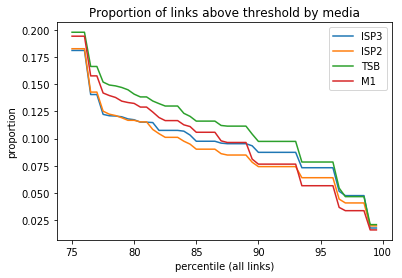

In [44]:
plt.plot([x / 2 for x in range(150, 200)], datapoints_isp3, label="ISP3")
plt.plot([x / 2 for x in range(150, 200)], datapoints_isp2, label="ISP2")
plt.plot([x / 2 for x in range(150, 200)], datapoints_tsb, label="TSB")
plt.plot([x / 2 for x in range(150, 200)], datapoints_m1, label="M1")

plt.title('Proportion of links above threshold by media')
plt.xlabel('percentile (all links)')
plt.ylabel('proportion')
plt.legend()

plt.savefig('graph_high_scoring_links_by_media.pdf')